## Gradient Boost Classifier:

Using a combination of governance characteristics and organizational characteristics (revenue, assets, ect.) I will predict salary using a Gradient Boost Classifier model.

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from numpy import interp

## IMPORT DATA

In [3]:
# import modeling dataset
features = pd.get_dummies(pd.read_csv('02.data/model_dataset_features_eng.csv'))

y = pd.read_csv('02.data/target_categories.csv', header=None, squeeze=True)

In [4]:
X = features.drop('reportable_comp', axis=1)

In [5]:
# verify the size of target and
# feature datasets are the same
X.shape[0] == y.shape[0]

True

## Gradient Boost Classifier
<a id='gbc'></a>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [7]:
gbc = ensemble.GradientBoostingClassifier()

In [8]:
# cross_val_score(gbc, X, y, cv=5)

In [9]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [10]:
gbc.score(X_test, y_test)

0.4870348089449446

In [11]:
X_test['pred'] = gbc.predict(X_test)
X_test['actual'] = y_test

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(X_test.actual, X_test.pred) / \
confusion_matrix(X_test.actual, X_test.pred).sum(axis=1, keepdims=True)

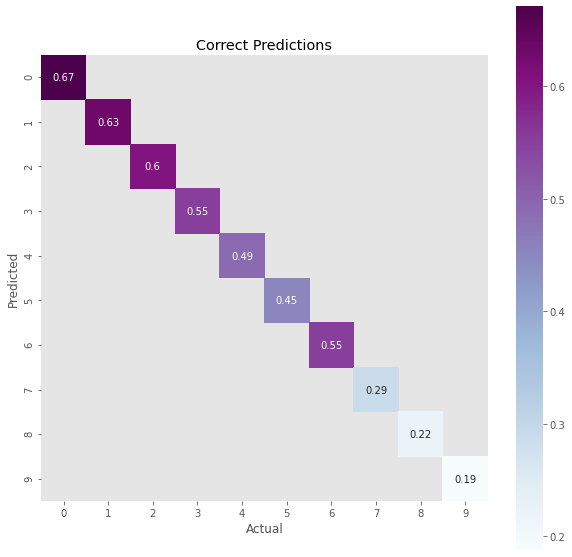

In [13]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(pd.DataFrame(np.diagflat(np.diagonal(pd.DataFrame(norm_conf_matrix)))).replace(0, np.nan),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Correct Predictions');

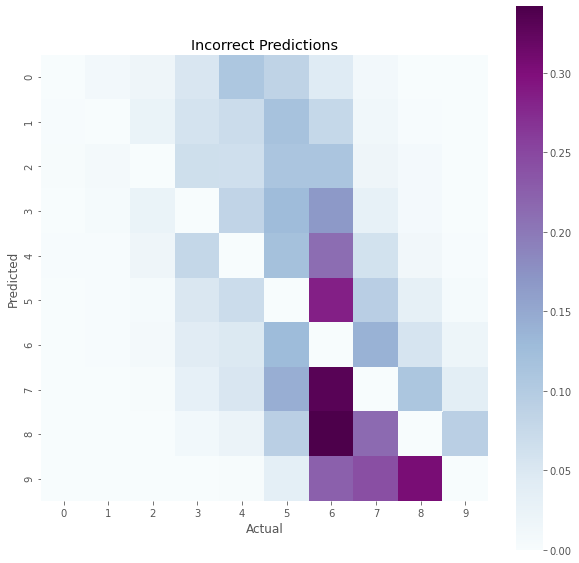

In [14]:
# compare features using a heatmap
plt.figure(figsize=(10, 10))
np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=False, 
                 cmap='BuPu')

plt.ylabel('Predicted')
plt.xlabel('Actual');
plt.title('Incorrect Predictions');

GBR struggles about the same amount as SVC and Logistic Multinomial Classifier.

In [17]:
f_importances = pd.Series(gbc.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

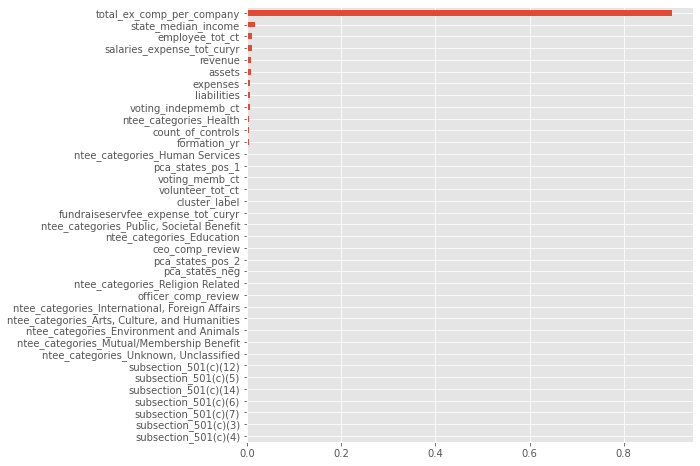

In [18]:
f_importances.sort_values().plot(kind='barh', figsize=(8, 8));

GBC relies much more heavily on only a few features.

### Gradient Boost 2nd Iteration - selecting only the top features.

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X[f_importances[f_importances > .05].index]
                                                    , y, test_size = 0.2)

In [268]:
gbc = ensemble.GradientBoostingClassifier()

In [269]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [270]:
gbc.score(X_test, y_test)

0.27505338769171034

Reducing features to only the top 5 hurt gradient boost performance.

### Examine precision/recall thresholds
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [19]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=y.unique())
n_classes = Y.shape[1]

In [20]:
# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

In [22]:
# Run classifier
classifier = OneVsRestClassifier(gbc)
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)

In [23]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.60


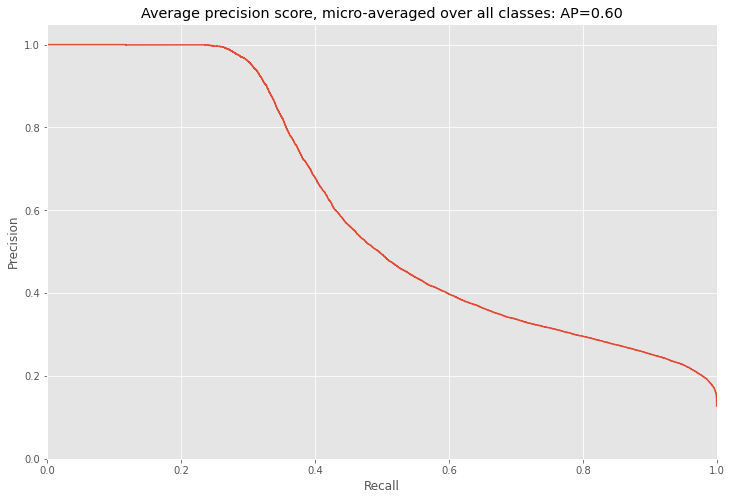

In [24]:
plt.figure(figsize=(12, 8))
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]));

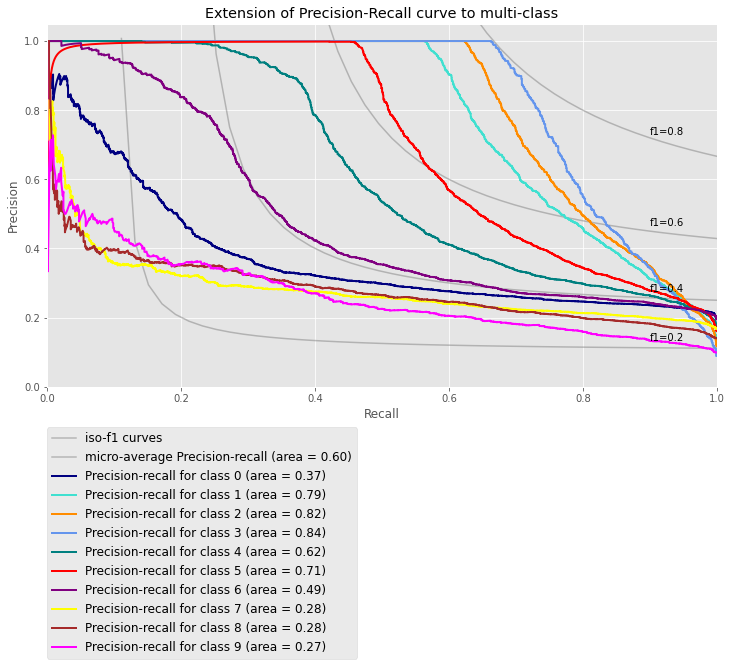

In [25]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 
                'turquoise', 
                'darkorange', 
                'cornflowerblue', 
                'teal',
                'red',
               'purple',
               'yellow',
               'brown',
               'magenta',
               'green'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.5)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
# l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.75), prop=dict(size=12))

plt.show();

### Examine ROC curve thresholds 

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [26]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

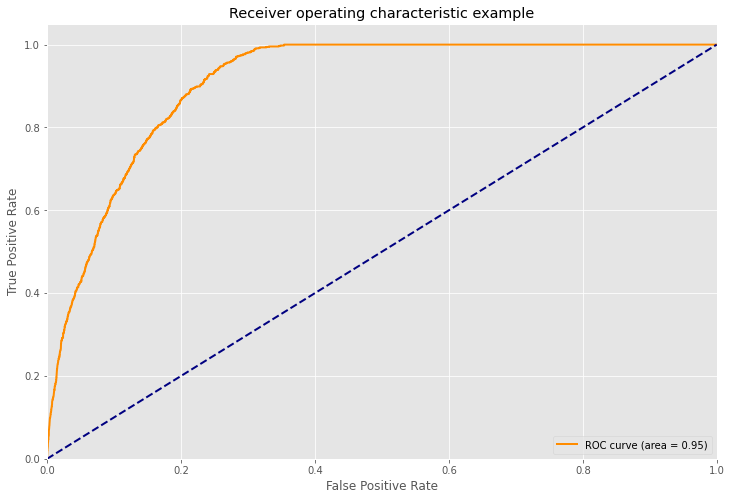

In [27]:
# plot ROC curve for specific classes
plt.figure(figsize=(12, 8))
lw = 2
plt.plot(fpr[9], tpr[9], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

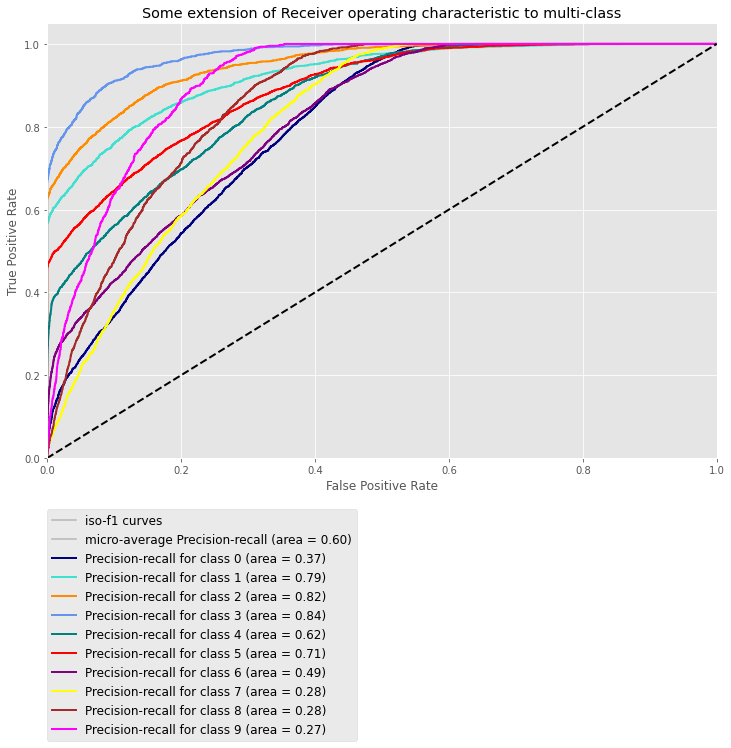

In [28]:
# plot all classes together
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

plt.figure(figsize=(12, 8))

colors = cycle(['navy', 
                'turquoise', 
                'darkorange', 
                'cornflowerblue', 
                'teal',
                'red',
               'purple',
               'yellow',
               'brown',
               'magenta',
               'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(lines, labels, loc=(0, -.65), prop=dict(size=12))
plt.show()